## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Embedding, TextVectorization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import re
import string


## Load data

In [3]:
df_order_reviews = pd.read_csv('S_Data\\order_reviews.csv')
df_order_items = pd.read_csv('S_Data\\order_items.csv')

## Data exploration

In [4]:
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
df_order_reviews.review_score.value_counts()

review_score
5    57420
4    19200
1    11858
3     8287
2     3235
Name: count, dtype: int64

In [6]:
df_order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

# First part - Emotion classification

## Data preprocessing

In [7]:
#drop empty comments
df_order_reviews.dropna(subset=['review_comment_message'], inplace=True)

In [8]:
df_order_reviews.shape

(41753, 7)

In [9]:
def clean_text(text):
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip()
    return text


In [10]:
df_order_reviews['review_comment_message'] = df_order_reviews['review_comment_message'].apply(clean_text)

In [11]:
def emotional_class(score):
    if score < 3:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

In [12]:
df_order_reviews['emotional_class'] = df_order_reviews['review_score'].apply(emotional_class).astype('category')
label_encoder = LabelEncoder()
df_order_reviews['emotional_class_encoded'] = label_encoder.fit_transform(df_order_reviews['emotional_class'])

In [13]:
df_order_reviews['emotional_class'].value_counts()

emotional_class
Positive    26680
Negative    11408
Neutral      3665
Name: count, dtype: int64

In [14]:
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,emotional_class,emotional_class_encoded
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Positive,2
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,parabéns lojas lannister adorei comprar pela i...,2018-03-01 00:00:00,2018-03-02 10:26:53,Positive,2
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,Positive,2
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"mas um pouco ,travando...pelo valor ta boa.",2018-02-16 00:00:00,2018-02-20 10:52:22,Positive,2
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,Positive,2


## Create model

In [15]:
#vectorize text
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


vocab_size = 10000
sequence_length = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(df_order_reviews['review_comment_message'].values)

In [16]:

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

label_encoder = LabelEncoder()
df_order_reviews['emotional_class_encoded'] = label_encoder.fit_transform(df_order_reviews['emotional_class'])

vocab_size = 10000
sequence_length = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(df_order_reviews['review_comment_message'].values)

embedding_dim = 16

model_emotional = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_emotional.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

X = df_order_reviews['review_comment_message'].values
y = df_order_reviews['emotional_class_encoded'].values

X = np.array(X)
y = np.array(y)


model_emotional.fit(X, y, epochs=15, batch_size=32)  

Epoch 1/15
1305/1305 [==============================] - 14s 7ms/step - loss: 0.6907 - accuracy: 0.7175
Epoch 2/15
1305/1305 [==============================] - 10s 8ms/step - loss: 0.4847 - accuracy: 0.8271
Epoch 3/15
1305/1305 [==============================] - 9s 7ms/step - loss: 0.4375 - accuracy: 0.8452
Epoch 4/15
1305/1305 [==============================] - 8s 6ms/step - loss: 0.4100 - accuracy: 0.8541
Epoch 5/15
1305/1305 [==============================] - 9s 7ms/step - loss: 0.3912 - accuracy: 0.8608
Epoch 6/15
1305/1305 [==============================] - 8s 6ms/step - loss: 0.3768 - accuracy: 0.8661
Epoch 7/15
1305/1305 [==============================] - 8s 6ms/step - loss: 0.3658 - accuracy: 0.8698
Epoch 8/15
1305/1305 [==============================] - 11s 9ms/step - loss: 0.3537 - accuracy: 0.8746
Epoch 9/15
1305/1305 [==============================] - 8s 6ms/step - loss: 0.3432 - accuracy: 0.8785
Epoch 10/15
1305/1305 [==============================] - 11s 8ms/step - loss: 0

## Analysis

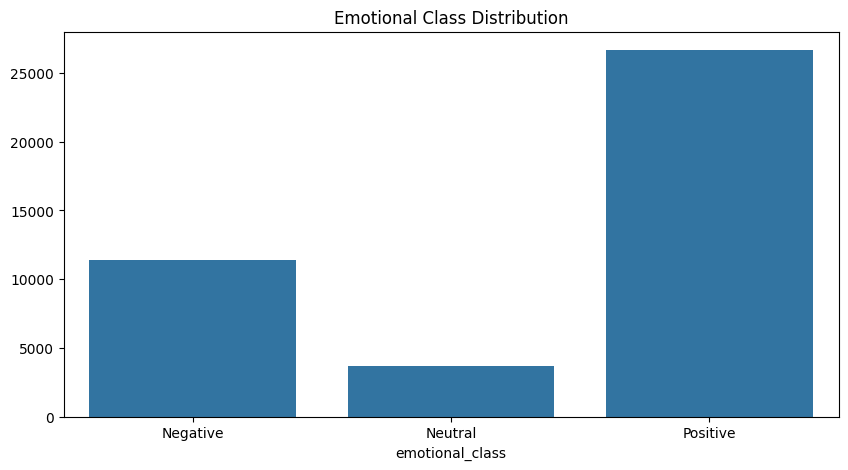

In [17]:
classes_counts = df_order_reviews['emotional_class'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=classes_counts.index, y=classes_counts.values)
plt.title('Emotional Class Distribution')
plt.show()

As we can see from the plot above there are not much samples for neutral and negative classes. This can be a problem for the model to learn the features of these classes.

Now let's see the confusion matrix of the model.

1305/1305 [==============================] - 7s 5ms/step


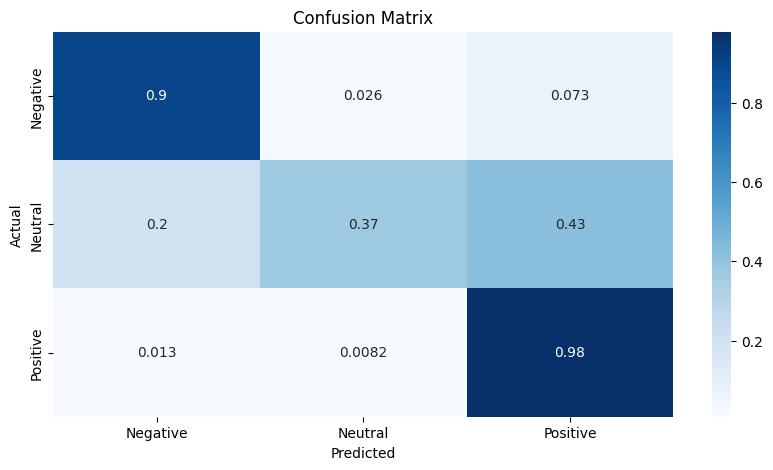

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = model_emotional.predict(X)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y, y_pred, normalize='true')

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


From the confusion matrix we can see that the model is not able to classify the neutral. This is due to the lack of samples for these classes.

# Second part - Price retrieval

## Data preprocessing

In [18]:
data = pd.merge(df_order_reviews, df_order_items, on='order_id', how='inner')

In [19]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,emotional_class,emotional_class_encoded,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Positive,2,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,parabéns lojas lannister adorei comprar pela i...,2018-03-01 00:00:00,2018-03-02 10:26:53,Positive,2,1,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,2018-02-15 15:48:21,1199.00,134.25
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,Positive,2,1,61a4100ccd6d9c4c808a1fd954ddb8ad,05ff92fedb5be47920fea08e501238b9,2018-05-17 10:31:31,586.56,26.69
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"mas um pouco ,travando...pelo valor ta boa.",2018-02-16 00:00:00,2018-02-20 10:52:22,Positive,2,1,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,Positive,2,1,6871a3c157d6f51697e887f3c3598479,974cf2cb8f4b7add98709c30df02fe10,2018-05-24 18:31:29,89.99,13.07


## Create algorithm

In [20]:
#detect price in the comment
def detect_price_mentions(comment):
    regex_patterns = [
        r'[rR]\$\s*\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?',# Brazilian Real
        r"\$\s*\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?",  # US Dollar and similar formats
        r'ARS\s*\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?', # Argentine Peso
        r'CLP\s*\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?', # Chilean Peso
        r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\s*USD', # US Dollar
        r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\s*[rR]\$', # Brazilian Real
        r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\s*ARS', # Argentine Peso
        r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\s*CLP', # Chilean Peso
    ]
    
    combined_pattern = '|'.join(regex_patterns)
    
    matches = re.findall(combined_pattern, comment)
    
    def to_float(value):
        return float(value.replace(',', '.'))

    if len(matches) > 0:
        #get only values without currency
        matches = list(map(to_float, [re.findall(r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?', match)[0] for match in matches]))

        return matches
    else:
        return None

In [21]:
data['price_mention'] = data['review_comment_message'].apply(detect_price_mentions)

In [22]:
data[data['price_mention'].notnull()].head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,emotional_class,emotional_class_encoded,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,price_mention
54,ae728c1061bf163b4bd256ad9ee0bb83,45c780334bc32cb77559a65c5f171160,1,NaN,este foi o pedido balde com 128 peças - bloco...,2018-01-04 00:00:00,2018-01-10 09:52:57,Negative,0,1,5ed9eaf534f6936b51d0b6c5e4d5c2e9,8cbac7e12637ed9cffa18c7875207478,2017-12-29 02:39:37,25.00,23.09,"[25.0, 35.9]"
55,ae728c1061bf163b4bd256ad9ee0bb83,45c780334bc32cb77559a65c5f171160,1,NaN,este foi o pedido balde com 128 peças - bloco...,2018-01-04 00:00:00,2018-01-10 09:52:57,Negative,0,2,5ed9eaf534f6936b51d0b6c5e4d5c2e9,8cbac7e12637ed9cffa18c7875207478,2017-12-29 02:39:37,25.00,23.09,"[25.0, 35.9]"
56,ae728c1061bf163b4bd256ad9ee0bb83,45c780334bc32cb77559a65c5f171160,1,NaN,este foi o pedido balde com 128 peças - bloco...,2018-01-04 00:00:00,2018-01-10 09:52:57,Negative,0,3,0cf41187284d7f099adc8415a743ebbd,bbad7e518d7af88a0897397ffdca1979,2017-12-29 02:39:37,35.90,5.77,"[25.0, 35.9]"
722,445039377c9ce49bbfa8e4822c99ead7,94647755aed55676ec36da516c9d439f,1,NaN,eu recebi desta loja apenas dois pendentes. pa...,2018-02-02 00:00:00,2018-02-04 15:41:13,Negative,0,1,6d3d8ade6b793a08b041b6bc653c08ca,5343d0649eca2a983820bfe93fc4d17e,2018-02-01 03:15:54,39.00,20.64,[90.0]
723,445039377c9ce49bbfa8e4822c99ead7,94647755aed55676ec36da516c9d439f,1,NaN,eu recebi desta loja apenas dois pendentes. pa...,2018-02-02 00:00:00,2018-02-04 15:41:13,Negative,0,2,ff26009ac6b838dc6cffa2d589cdbefb,157c3e4b42f81ac4a44e8b1ca2fe9876,2018-02-01 03:15:54,90.00,10.32,[90.0]
724,445039377c9ce49bbfa8e4822c99ead7,94647755aed55676ec36da516c9d439f,1,NaN,eu recebi desta loja apenas dois pendentes. pa...,2018-02-02 00:00:00,2018-02-04 15:41:13,Negative,0,3,6d3d8ade6b793a08b041b6bc653c08ca,5343d0649eca2a983820bfe93fc4d17e,2018-02-01 03:15:54,39.00,20.64,[90.0]
1269,9e3ef52c33d9bb0445f0bddb3df4b1ea,9d39d357291a0e87c2c2816dabc0b23a,1,Comprei 4 chegou só 3,"comprei 4 produtos, sendo que só recebi 3. fal...",2018-05-25 00:00:00,2018-05-29 05:22:39,Negative,0,1,5bd7e57735a44e529bf066fee83a9c60,609e1a9a6c2539919b8205cf7c4e6ff0,2018-05-22 18:19:02,59.90,11.71,[100.0]
1270,9e3ef52c33d9bb0445f0bddb3df4b1ea,9d39d357291a0e87c2c2816dabc0b23a,1,Comprei 4 chegou só 3,"comprei 4 produtos, sendo que só recebi 3. fal...",2018-05-25 00:00:00,2018-05-29 05:22:39,Negative,0,2,46e477d89da734ac9f6b12073503711a,1835b56ce799e6a4dc4eddc053f04066,2018-05-22 18:19:02,90.99,11.71,[100.0]
1271,9e3ef52c33d9bb0445f0bddb3df4b1ea,9d39d357291a0e87c2c2816dabc0b23a,1,Comprei 4 chegou só 3,"comprei 4 produtos, sendo que só recebi 3. fal...",2018-05-25 00:00:00,2018-05-29 05:22:39,Negative,0,3,e9e1e0a297e5a8f045e8c0395c4c745b,609e1a9a6c2539919b8205cf7c4e6ff0,2018-05-22 18:19:02,53.90,11.71,[100.0]
1272,9e3ef52c33d9bb0445f0bddb3df4b1ea,9d39d357291a0e87c2c2816dabc0b23a,1,Comprei 4 chegou só 3,"comprei 4 produtos, sendo que só recebi 3. fal...",2018-05-25 00:00:00,2018-05-29 05:22:39,Negative,0,4,8b51c6ccc9c0548c951214e1cd1547ff,609e1a9a6c2539919b8205cf7c4e6ff0,2018-05-22 18:19:02,59.90,11.71,[100.0]


## Analysis

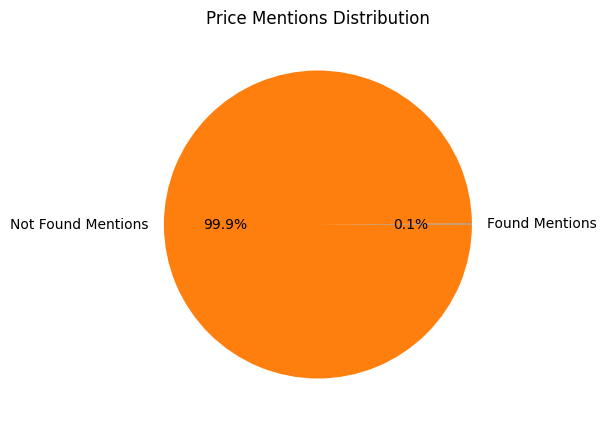

In [30]:
found_mentions = data[data['price_mention'].notnull()]['price_mention'].count()
not_found_mentions = data.shape[0] - found_mentions

plt.figure(figsize=(10, 5))
plt.pie([found_mentions, not_found_mentions], labels=['Found Mentions', 'Not Found Mentions'], autopct='%1.1f%%')
plt.title('Price Mentions Distribution')
plt.show()


As we can see there is not much comments that mention price in any of predicted ways.

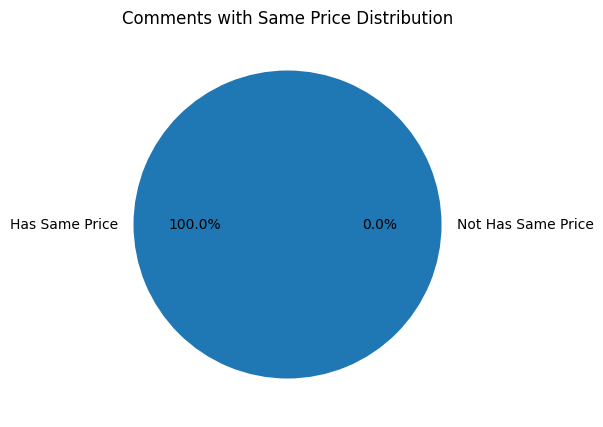

In [33]:
def comment_has_same_price(x):
    if x['price_mention'] is not None:
        return x['price'] in x['price_mention']
    else:
        return False

data['comment_has_same_price'] = data.apply(comment_has_same_price, axis=1)

has_same_price_count = data[data["price_mention"].notnull()]['comment_has_same_price'].value_counts()
not_has_same_price_count = found_mentions - has_same_price_count.sum()

plt.figure(figsize=(10, 5))
plt.pie([has_same_price_count[True], not_has_same_price_count], labels=['Has Same Price', 'Not Has Same Price'], autopct='%1.1f%%')
plt.title('Comments with Same Price Distribution')
plt.show()

Here we can see that every comment that has a price mention does it correctly.